<a href="https://colab.research.google.com/github/owen198/csc_domain_adaptation/blob/main/csc_autoencoder_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import preprocessing
from sklearn import svm
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from sklearn import manifold, datasets

import numpy as np
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
source_tag = 'W4662FM0400'
target_tag = 'W4662FM0507'
path = './gdrive/My Drive/data/CSC/W4/'

In [4]:
source_pd = pd.concat([pd.read_csv(path+source_tag+'_202004.csv'),
                       pd.read_csv(path+source_tag+'_202005.csv'),
                       pd.read_csv(path+source_tag+'_202006.csv'),
                       pd.read_csv(path+source_tag+'_202007.csv'),
                       pd.read_csv(path+source_tag+'_202008.csv'),
                       pd.read_csv(path+source_tag+'_202009.csv')])

target_pd = pd.concat([pd.read_csv(path+target_tag+'_202009.csv'),
                       pd.read_csv(path+target_tag+'_202010.csv'),
                       pd.read_csv(path+target_tag+'_202011.csv'),
                       pd.read_csv(path+target_tag+'_202012.csv'),
                       pd.read_csv(path+target_tag+'_202101.csv'),
                       pd.read_csv(path+target_tag+'_202102.csv')])

In [5]:
source_pd['datetime'] = source_pd['timestamp'].astype('int').astype("datetime64[s]")
target_pd['datetime'] = target_pd['timestamp'].astype('int').astype("datetime64[s]")

In [6]:
source_normal = source_pd[(source_pd['datetime'] > datetime.datetime(2020,4,1,0,0)) & (source_pd['datetime'] < datetime.datetime(2020,6,1,0,0))]
source_abnormal = source_pd[(source_pd['datetime'] > datetime.datetime(2020,6,1,0,0)) & (source_pd['datetime'] < datetime.datetime(2020,8,1,0,0))]
source_repaired = source_pd[(source_pd['datetime'] > datetime.datetime(2020,9,1,0,0)) & (source_pd['datetime'] < datetime.datetime(2020,11,1,0,0))]

target_normal = target_pd[(target_pd['datetime'] > datetime.datetime(2020,9,1,0,0)) & (target_pd['datetime'] < datetime.datetime(2021,1,1,0,0))]
target_abnormal = target_pd[(target_pd['datetime'] > datetime.datetime(2021,1,14,0,0)) & (target_pd['datetime'] < datetime.datetime(2021,1,24,0,0))]
target_repaired = target_pd[(target_pd['datetime'] > datetime.datetime(2021,1,1,0,0)) & (target_pd['datetime'] < datetime.datetime(2021,2,1,0,0))]

In [7]:
drop_list = ['Unnamed: 0', '_id','type','scada','timestamp','device', 'datetime']

source_normal = source_normal.drop(columns=drop_list)
source_abnormal = source_abnormal.drop(columns=drop_list)
source_repaired = source_repaired.drop(columns=drop_list)

target_normal = target_normal.drop(columns=drop_list)
target_abnormal = target_abnormal.drop(columns=drop_list)
target_repaired = target_repaired.drop(columns=drop_list)

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(source_normal)

source_normal = pd.DataFrame(min_max_scaler.transform(source_normal))
source_abnormal = pd.DataFrame(min_max_scaler.transform(source_abnormal))
source_repaired = pd.DataFrame(min_max_scaler.transform(source_repaired))

target_normal = pd.DataFrame(min_max_scaler.transform(target_normal))
target_abnormal = pd.DataFrame(min_max_scaler.transform(target_abnormal))
target_repaired = pd.DataFrame(min_max_scaler.transform(target_repaired))

In [8]:
shape = min (source_normal.shape[0], target_normal.shape[0])

In [9]:
X_source = source_normal[0:shape]
X_target = target_normal[0:shape] 

In [10]:
bottleneck_dim = 64
input_dim = X_source.shape[1]
encoder_dim_1 = 128
encoder_dim_2 = 256
decoder_dim_1 = 128
decoder_dim_2 = 256

# 定義 autoencoder 模型
input_img = Input(shape=(input_dim,))
x = Dense(encoder_dim_1, activation="relu")(input_img)
x = Dense(encoder_dim_2, activation="relu")(x)
encoded = Dense(bottleneck_dim, activation="relu")(x)
x = Dense(decoder_dim_1, activation="relu")(encoded)
x = Dense(decoder_dim_2, activation="relu")(x)
decoded = Dense(input_dim, activation="sigmoid")(x)
autoencoder = Model(input_img, decoded)
autoencoder.summary()  # 顯示模型摘要資訊

# 定義 encoder 模型
encoder = Model(input_img, encoded)
#encoder.summary()    # 顯示模型摘要資訊

# 定義 decoder 模型
decoder_input = Input(shape=(bottleneck_dim,))
decoder_layer = autoencoder.layers[-3](decoder_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(decoder_input, decoder_layer)
#decoder.summary()    # 顯示模型摘要資訊

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 390)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               50048     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 390)               100230

In [11]:
opt=optimizers.Adam(lr=0.000001)

autoencoder.compile(loss="mean_squared_error", 
                    optimizer='Adam')
# 訓練模型
model = autoencoder.fit(X_target, X_source,
                epochs=1000, batch_size=256, verbose=1)

encoded_imgs = encoder.predict(X_source)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/1000
202/202 [==============================] - 3s 11ms/step - loss: 0.0260
Epoch 2/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0104
Epoch 3/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0104
Epoch 4/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0102
Epoch 5/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0099
Epoch 6/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0097
Epoch 7/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0097
Epoch 8/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0094
Epoch 9/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0094
Epoch 10/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0093
Epoch 11/1000
202/202 [==============================] - 2s 11ms/step - loss: 0.0091
Epoch 12/1000
202/202 [==============================] - 2s 11ms/step - lo

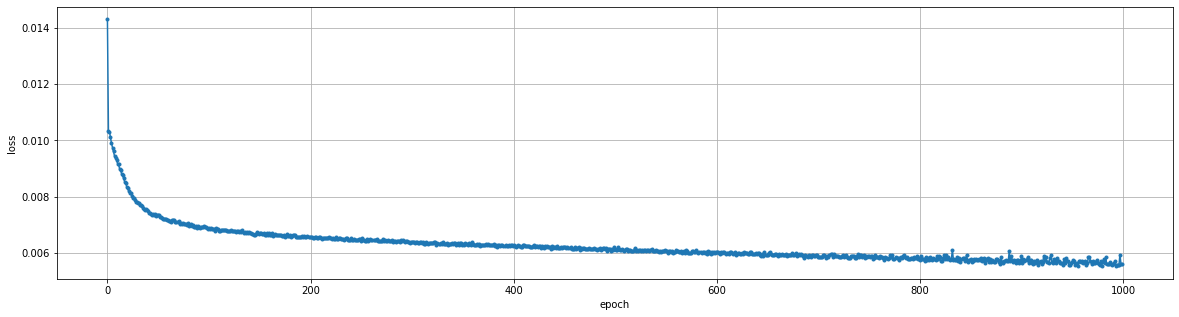

In [12]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(model.history['loss'], marker='.')
ax.grid(True)

plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

#model.history.keys()

In [13]:
print('original dist:', np.linalg.norm(X_source-X_target))
print('domain adaptation:', np.linalg.norm(decoded_imgs - X_target))

original dist: 953.2742795267142
domain adaptation: 1029.7729391203102


In [14]:
from sklearn.decomposition import PCA

X_source_dr = PCA(n_components=2).fit_transform(X_source)
x_min, x_max = X_source_dr.min(0), X_source_dr.max(0)
X_norm = (X_source_dr-x_min) / (x_max-x_min)  #Normalize
X_source_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_target_dr = PCA(n_components=2).fit_transform(X_target)
x_min, x_max = X_target_dr.min(0), X_target_dr.max(0)
X_norm = (X_target_dr-x_min) / (x_max-x_min)  #Normalize
X_target_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_decoder_dr = PCA(n_components=2).fit_transform(decoded_imgs)
x_min, x_max = X_decoder_dr.min(0), X_decoder_dr.max(0)
X_norm = (X_decoder_dr-x_min) / (x_max-x_min)  #Normalize
X_decode_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

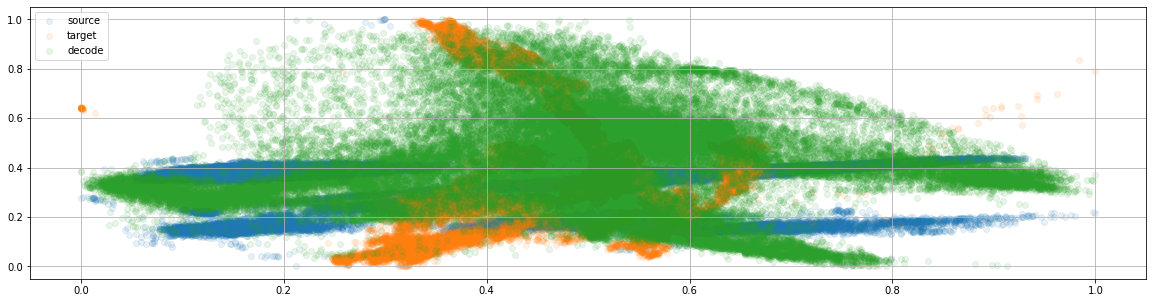

In [15]:
fig, ax = plt.subplots(figsize=(20,5))

ax.scatter(X_source_df['dim1'], X_source_df['dim2'], alpha=0.1, label='source')
ax.scatter(X_target_df['dim1'], X_target_df['dim2'], alpha=0.1, label='target')
ax.scatter(X_decode_df['dim1'], X_decode_df['dim2'], alpha=0.1, label='decode')

ax.legend()
ax.grid(True)

#plt.ylim(0, 1)
#plt.xlim(0, 1)
plt.show()

In [16]:
def scorer_(Y_pred):
    a = (Y_pred[Y_pred == -1].size)/(Y_pred.size)
    return a*100

In [17]:
normal_encode = encoder.predict(source_normal)
source_encode = encoder.predict(X_source)
target_encode = encoder.predict(X_target)

target_decode = decoder.predict(target_encode)
source_decode = decoder.predict(source_encode)

In [18]:

model_encode = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(normal_encode)

pred_normal = scorer_(model_encode.predict(normal_encode))
pred_source = scorer_(model_encode.predict(source_encode))
pred_target = scorer_(model_encode.predict(target_encode))

print('normal:', pred_normal,'source:', pred_source, 'target:', pred_target)

normal: 1.6350302819217895 source: 1.6350302819217895 target: 99.96710589965365


In [19]:

model_decode = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(source_normal)

pred_normal = scorer_(model_decode.predict(source_normal))
pred_source = scorer_(model_decode.predict(source_decode))
pred_target = scorer_(model_decode.predict(target_decode))

print('normal:', pred_normal,'source:', pred_source, 'target:', pred_target)

normal: 0.9964977457866527 source: 46.93988119424934 target: 0.10642208935585612


In [20]:
model_target = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(target_normal)

pred_target_by_target = scorer_(model_target.predict(X_target))
pred_target_by_source = scorer_(model_decode.predict(X_target))
print('without any intervention:', pred_target_by_target, pred_target_by_source)

without any intervention: 1.0351966873706004 49.43789787349316
